# Import the necessary libraries

In [9]:
pip install transformers datasets torch scikit-learn openpyxl optuna

In [10]:
import os
import json
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import torch
import torch.nn as nn
import re
import optuna

from google.colab import drive
from datasets import load_dataset
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler, BertForSequenceClassification, AdamW, BertTokenizer, AutoTokenizer, DistilBertTokenizer, DistilBertConfig, DistilBertForSequenceClassification
from tqdm import tqdm
from wordcloud import WordCloud
from matplotlib_venn import venn2

# Load the data:

1.   MBIC dataset for the model training
2.   Baly dataset for the ngram extraction

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path = '/content/drive/My Drive/Colab Notebooks/data/final_labels_MBIC.xlsx'

In [5]:
data = pd.read_excel(file_path, engine='openpyxl')
print(data.head())

                                                text  \
0  YouTube is making clear there will be no “birt...   
1  So while there may be a humanitarian crisis dr...   
2  Looking around the United States, there is nev...   
3  The Republican president assumed he was helpin...   
4  The explosion of the Hispanic population has l...   

                                           news_link      outlet  \
0  https://eu.usatoday.com/story/tech/2020/02/03/...   usa-today   
1  https://www.alternet.org/2019/01/here-are-5-of...    alternet   
2  https://thefederalist.com/2020/03/11/woman-who...  federalist   
3  http://www.msnbc.com/rachel-maddow-show/auto-i...       msnbc   
4  https://www.breitbart.com/politics/2015/02/26/...   breitbart   

            topic    type  group_id  num_sent label_bias  \
0  elections-2020  center         1         1     Biased   
1     immigration    left         1         1     Biased   
2        abortion   right         1         1     Biased   
3     environm

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [6]:
baly_file_path = "/content/drive/MyDrive/Colab Notebooks/data/merged_data.xlsx"

baly_data = pd.read_excel(baly_file_path, engine='openpyxl')
print(baly_data.head())

         topic           source  bias  \
0  coronavirus  Washington Post     0   
1  coronavirus  National Review     2   
2  free_speech  National Review     2   
3  environment  NPR Online News     1   
4      science        Quillette     2   

                                                 url  \
0  https://www.washingtonpost.com/nation/2020/05/...   
1  https://www.nationalreview.com/news/de-blasio-...   
2  http://www.nationalreview.com/corner/455205/fa...   
3  https://www.npr.org/2020/02/07/803835452/it-wa...   
4  https://quillette.com/2020/01/22/in-space-let-...   

                                               title        date  \
0  Trump threatens to permanently cut WHO funding...  2020-05-19   
1  De Blasio Tells Covid Contract Tracers Not to ...  2020-06-15   
2                        Fake News, Real Sensorship.  2018-01-05   
3          It Was 65 Degrees In Antarctica This Week  2020-02-07   
4            In Space, Let Meritocracy Reign Supreme  2020-01-22   

       

# Preprocess the data:

*   Remove unavailable/invalid data
*   Lowercase the text
*   Remove special characters, punctuation and stopwords
*   Tokenize the data



In [7]:
data.dropna()

,text,news_link,outlet,topic,type,group_id,num_sent,label_bias,label_opinion,article,biased_words
0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']"
1,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,Speaking to the country for the first time fro...,['crisis']
2,"Looking around the United States, there is nev...",https://thefederalist.com/2020/03/11/woman-who...,federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,The left has a thing for taking babies hostage...,"['killing', 'never', 'developing', 'humans', '..."
3,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,1,1,Biased,Expresses writer’s opinion,"In Barack Obama’s first term, the administrati...","['rejects', 'happy', 'assumed']"
4,The explosion of the Hispanic population has l...,https://www.breitbart.com/politics/2015/02/26/...,breitbart,student-debt,right,1,1,Biased,No agreement,"Republicans should stop fighting amnesty, Pres...",['explosion']
...,...,...,...,...,...,...,...,...,...,...,...
1694,"Sen. Bernie Sanders, I-Vt., went after Pete Bu...",https://www.nbcnews.com/politics/meet-the-pres...,msnbc,middle-class,left,85,1,Non-biased,Entirely factual,SEE NEW POSTS\nSanders hits Buttigieg for bill...,"['after', 'went']"
1695,"Last week, Barstool Sports founder Dave Portno...",https://thefederalist.com/2020/05/18/how-you-c...,federalist,coronavirus,right,85,1,Non-biased,Somewhat factual but also opinionated,Not everyone seething about the ongoing abuses...,"['ranted', 'vigorously']"
1696,"Coincidentally, many Republican lawmakers who ...",https://www.alternet.org/2020/01/follow-the-mo...,alternet,middle-class,left,85,1,Non-biased,Somewhat factual but also opinionated,It’s long been obvious that Republican senator...,['increased']
1698,"As a self-described Democratic socialist, Sen....",https://www.foxnews.com/politics/how-did-berni...,fox-news,middle-class,right,85,1,Non-biased,Entirely factual,"As a self-described Democratic socialist, Sen....",['outspoken']


In [ ]:
baly_data.dropna()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,coronavirus,Washington Post,0,https://www.washingtonpost.com/nation/2020/05/...,Trump threatens to permanently cut WHO funding...,2020-05-19,Teo Armus,Trump temporarily suspended U.S. payments in A...,Trump temporarily suspended U.S. payments in A...,www.washingtonpost.com,left,mdpH7Vx5fGAQZINf
1,coronavirus,National Review,2,https://www.nationalreview.com/news/de-blasio-...,De Blasio Tells Covid Contract Tracers Not to ...,2020-06-15,"Tobias Hoonhout, Mairead Mcardle, David Harsan...",New York City mayor Bill de Blasio speaks at a...,New York City mayor Bill de Blasio speaks at a...,www.nationalreview.com,right,NqVBRcxvOojMtoeP
2,free_speech,National Review,2,http://www.nationalreview.com/corner/455205/fa...,"Fake News, Real Sensorship.",2018-01-05,"Andrew Stuttaford, David French, Jordan Sillar...",There is little over the Atlantic that bears m...,There is little over the Atlantic that bears m...,www.nationalreview.com,right,acD0JfnwhMeGICLs
3,environment,NPR Online News,1,https://www.npr.org/2020/02/07/803835452/it-wa...,It Was 65 Degrees In Antarctica This Week,2020-02-07,Colin Dwyer,"At least , that 's what scientists reported at...",It Was 65 Degrees In Antarctica This Week\n\nE...,www.npr.org,center,8QK686IhoogBuxiw
5,politics,CNN (Web News),0,http://www.cnn.com/2014/01/17/politics/christi...,Christie marches on as controversy at home unf...,2014-01-17,Cnn Staff,Gov . Chris Christie hits the road this weeken...,Gov. Chris Christie hits the road this weekend...,www.cnn.com,left,ZZ2DxfXLK6aKZ97x
...,...,...,...,...,...,...,...,...,...,...,...,...
37605,healthcare,Fox News,2,http://www.foxnews.com/opinion/2014/01/27/repu...,"A Republican plan to replace ObamaCare, cover ...",2014-01-27,Richard Burr,During his State of the Union address on Tuesd...,During his State of the Union address on Tuesd...,www.foxnews.com,right,kiG7A9l1OpXvUn7z
37607,campaign_finance,Politico,0,https://www.politico.com/states/florida/story/...,Soros-backed group begins work in Florida's I-...,2020-04-13,Matt Dixon,George Soros | Getty Soros-backed group begins...,George Soros | Getty Soros-backed group begins...,www.politico.com,left,UMEmauFwkN8oohVY
37608,politics,Washington Times,2,http://www.washingtontimes.com/news/2015/feb/2...,Kerry: U.S. looking into dissidents’ claims of...,2015-02-25,Guy Taylor,Secretary of State John F. Kerry said Wednesda...,Secretary of State John F. Kerry said Wednesda...,www.washingtontimes.com,right,7ChL03WZiTr5SjoC
37610,national_security,Christian Science Monitor,1,http://www.csmonitor.com/USA/Politics/2017/040...,"Susan Rice, Michael Flynn, and the politics of...",2017-04-06,Peter Grier,Rep. Trey Gowdy ( R ) of South Carolina leaned...,Rep. Trey Gowdy (R) of South Carolina leaned f...,www.csmonitor.com,center,xNEOd8rkKp2mBt3a


In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [14]:
stop_words = set(stopwords.words('english'))

In [15]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    processed_text = ' '.join(tokens)
    return processed_text

In [ ]:
baly_data['content'] = baly_data['content'].apply(preprocess_text)

In [16]:
data['text'] = data['text'].apply(preprocess_text)

In [17]:
label_mapping = {"Biased": 1, "Non-biased": 0}

In [18]:
filtered_data = data[data["label_bias"] != "No agreement"].copy()
filtered_data.loc[:, "labels"] = filtered_data["label_bias"].map(label_mapping)
filtered_data = filtered_data.dropna(subset=["article", "labels"])

In [20]:
texts = filtered_data["article"].tolist()
labels = filtered_data["labels"].tolist()

In [ ]:
print(len(texts), len(labels))

1464 1464


In [21]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

In [22]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [23]:
class BiasDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx])
        }

# Ngrams extraction

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=5000)
data_ngram_matrix = vectorizer.fit_transform(data["text"])

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=5000)
baly_ngram_matrix = vectorizer.fit_transform(baly_data['content'])

In [ ]:
data_ngram_counts = np.asarray(data_ngram_matrix.sum(axis=0)).flatten()
data_ngram_features = vectorizer.get_feature_names_out()

In [ ]:
data_ngram_df = pd.DataFrame({"ngram": data_ngram_features, "count": data_ngram_counts})
data_top_ngrams = data_ngram_df.sort_values(by="count", ascending=False).head(15)

In [ ]:
print(data_top_ngrams)

                        ngram  count
436              donald trump    105
2604         president donald     94
2605   president donald trump     72
264            climate change     51
4780            united states     48
4899              white house     36
4685     trump administration     36
445             donald trumps     33
4558             student loan     31
1069                 new york     27
703               gun control     24
313      coronavirus pandemic     24
2606  president donald trumps     22
692            green new deal     21
691                 green new     21


In [ ]:
baly_ngram_counts = np.asarray(baly_ngram_matrix.sum(axis=0)).flatten()
baly_ngram_features = vectorizer.get_feature_names_out()

In [ ]:
baly_ngram_df = pd.DataFrame({"ngram": baly_ngram_features, "count": baly_ngram_counts})
baly_top_ngrams = baly_ngram_df.sort_values(by="count", ascending=False).head(15)

In [ ]:
print(baly_top_ngrams)

                             ngram  count
4780                 united states  32994
962                  media outlets  19450
4543                 stores looted  18988
2505      preserve affordable care  18899
2383  predatory forprofit colleges  12347
3066         prison friday serving  11112
1560             police eventually  10542
4087  republicans congress stepped  10534
1949          poor disenfranchised   9474
1598          policies baby killed   9318
3053             prioritize texans   9151
1952            poor health access   7727
2369        precedent struck hands   7688
283                 combat climate   7425
4438               secretary state   7318


<ipython-input-47-6643b4086401>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="ngram", data=data_top_ngrams, palette="viridis")


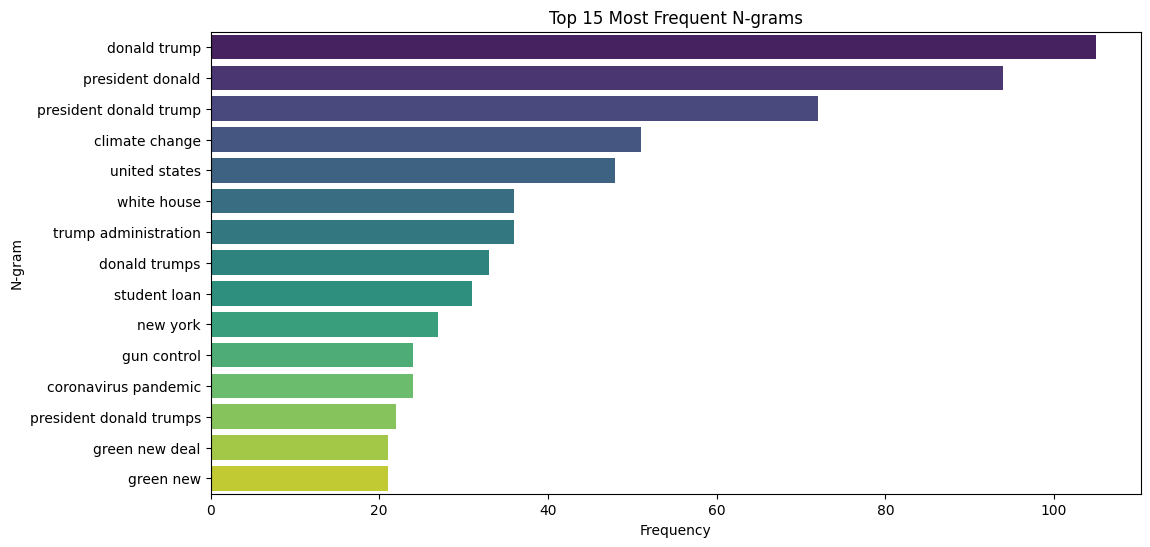

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="ngram", data=data_top_ngrams, palette="viridis")
plt.title("Top 15 Most Frequent N-grams")
plt.xlabel("Frequency")
plt.ylabel("N-gram")
plt.show()

<ipython-input-48-14f97a8a3b0e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="ngram", data=baly_top_ngrams, palette="viridis")


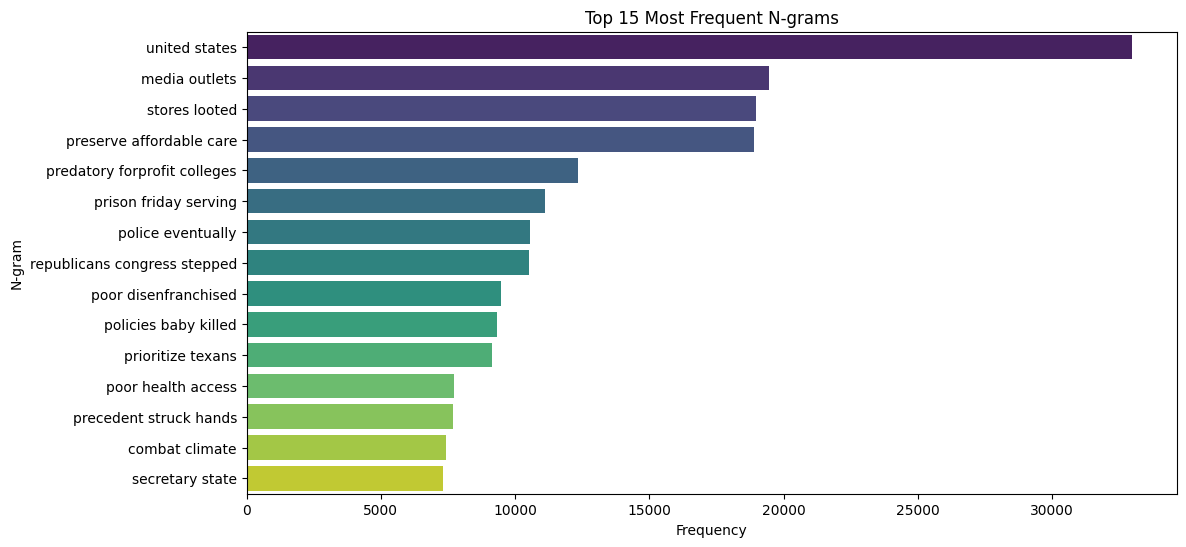

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="ngram", data=baly_top_ngrams, palette="viridis")
plt.title("Top 15 Most Frequent N-grams")
plt.xlabel("Frequency")
plt.ylabel("N-gram")
plt.show()

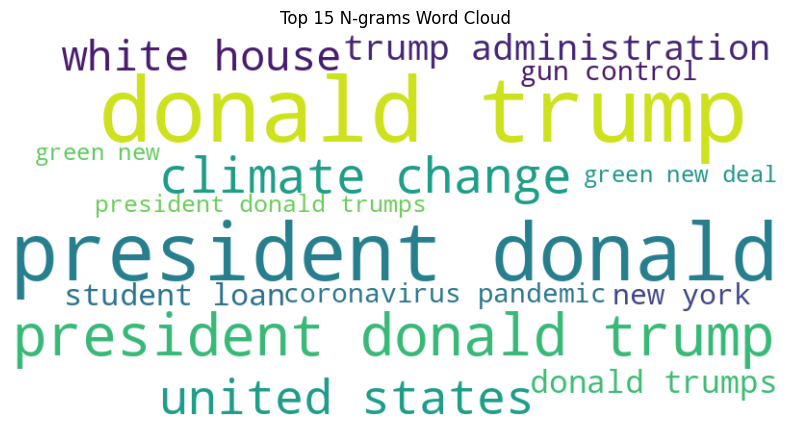

In [ ]:
data_ngram_dict = dict(zip(data_top_ngrams["ngram"], data_top_ngrams["count"]))

data_wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(data_ngram_dict)

plt.figure(figsize=(10, 5))
plt.imshow(data_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top 15 N-grams Word Cloud")
plt.show()

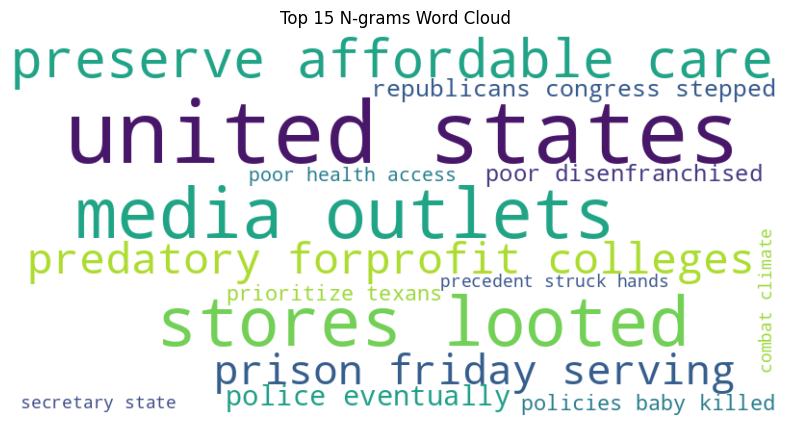

In [ ]:
baly_ngram_dict = dict(zip(baly_top_ngrams["ngram"], baly_top_ngrams["count"]))

baly_wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(baly_ngram_dict)

plt.figure(figsize=(10, 5))
plt.imshow(baly_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top 15 N-grams Word Cloud")
plt.show()

<ipython-input-57-052956d1097f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="ngram", data=data_top_ngrams, ax=axes[0], palette="Blues_d")
<ipython-input-57-052956d1097f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="ngram", data=baly_top_ngrams, ax=axes[1], palette="Greens_d")


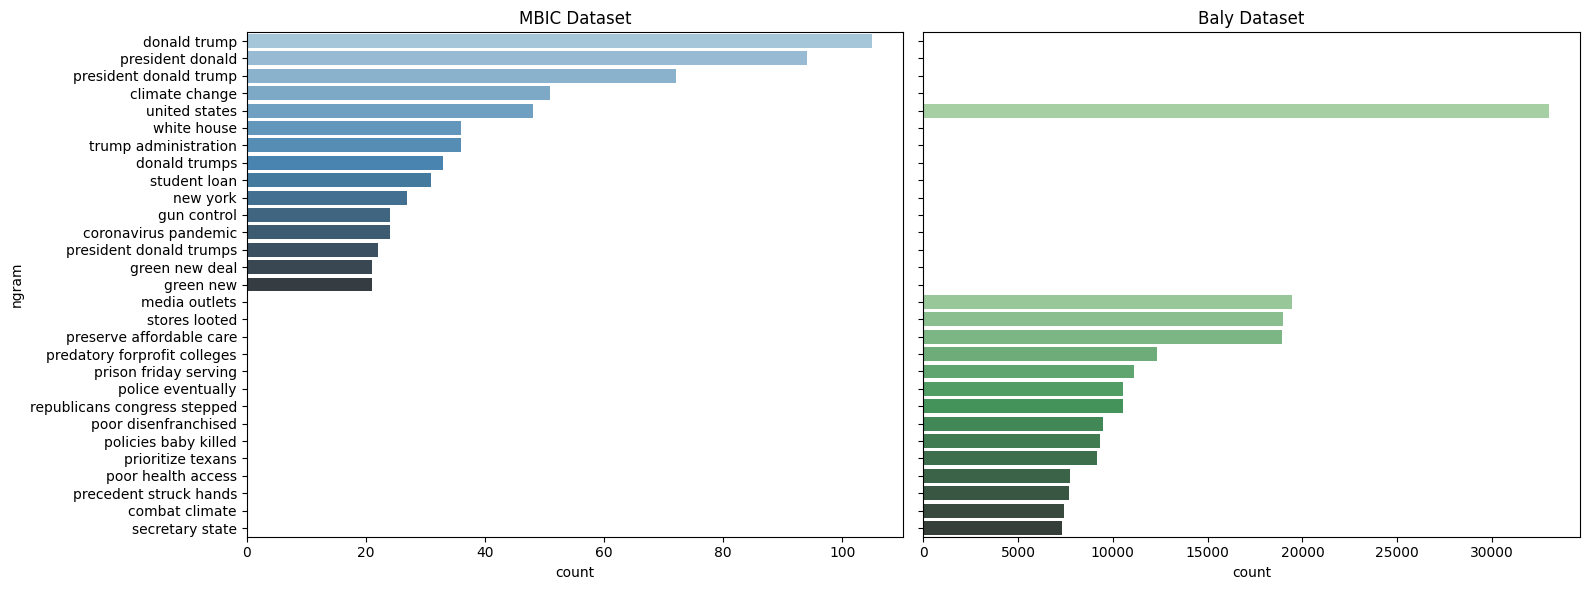

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.barplot(x="count", y="ngram", data=data_top_ngrams, ax=axes[0], palette="Blues_d")
axes[0].set_title("MBIC Dataset")

sns.barplot(x="count", y="ngram", data=baly_top_ngrams, ax=axes[1], palette="Greens_d")
axes[1].set_title("Baly Dataset")

plt.tight_layout()
plt.show()

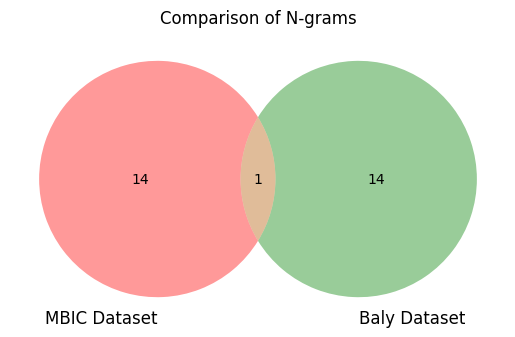

In [ ]:
set_data = set(data_top_ngrams["ngram"])
set_baly = set(baly_top_ngrams["ngram"])

venn2([set_data, set_baly], ("MBIC Dataset", "Baly Dataset"))
plt.title("Comparison of N-grams")
plt.show()

# Transformer-based models

# Bert

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

encodings = tokenizer(
    texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
labels_tensor = torch.tensor(labels)

In [ ]:
class BiasDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx])
        }

In [ ]:
dataset = BiasDataset(encodings, labels_tensor)

In [ ]:
train_encodings = tokenizer(
    train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt"
)
test_encodings = tokenizer(
    test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt"
)

In [ ]:
train_labels_tensor = torch.tensor(train_labels)
test_labels_tensor = torch.tensor(test_labels)

In [ ]:
train_dataset = BiasDataset(train_encodings, train_labels_tensor)
test_dataset = BiasDataset(test_encodings, test_labels_tensor)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(epochs):
    total_loss = 0
    print(f"Epoch {epoch + 1}")

    for batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Training loss after epoch {epoch + 1}: {total_loss / len(train_loader)}")

Epoch 1


Training:   0%|          | 0/147 [00:00<?, ?it/s]<ipython-input-86-9c105fdd88bc>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.labels[idx])


Training loss after epoch 1: 0.575450656568112
Epoch 2


Training loss after epoch 2: 0.502168039683582
Epoch 3


Training loss after epoch 3: 0.4245664983683703


In [ ]:
true_labels = []
predicted_labels = []

In [ ]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

<ipython-input-86-9c105fdd88bc>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.labels[idx])


In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

In [ ]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.7474402730375427
Precision: 0.7359468548348729
Recall: 0.7474402730375427
F1-Score: 0.728006711703844


# DistilBert

In [ ]:
db_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
db_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
db_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
db_model.to(db_device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_encodings = db_tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = db_tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

In [ ]:
train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 3
for epoch in range(epochs):
    db_model.train()
    total_loss = 0
    print(f"Epoch {epoch + 1}")

    for batch in tqdm(train_loader, desc="Training", leave=True):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(db_device)
        attention_mask = batch["attention_mask"].to(db_device)
        labels = batch["labels"].to(device)

        outputs = db_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Training loss after epoch {epoch + 1}: {total_loss / len(train_loader)}")

Epoch 1


Training: 100%|██████████| 147/147 [12:20<00:00,  5.04s/it]


Training loss after epoch 1: 0.7161641473672828
Epoch 2


Training: 100%|██████████| 147/147 [11:54<00:00,  4.86s/it]


Training loss after epoch 2: 0.7155527431948655
Epoch 3


Training: 100%|██████████| 147/147 [11:45<00:00,  4.80s/it]

Training loss after epoch 3: 0.7151524647563493


In [ ]:
db_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(db_device)
        attention_mask = batch["attention_mask"].to(db_device)
        labels = batch["labels"].to(db_device)

        outputs = db_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Evaluating: 100%|██████████| 37/37 [00:57<00:00,  1.54s/it]


In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.30716723549488056
Precision: 0.09435171056156741
Recall: 0.30716723549488056
F1-Score: 0.14436058065033552


# Tuning

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(db_device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
db_model = DistilBertForSequenceClassification(config)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
epochs = 5

In [ ]:
for epoch in range(epochs):
    db_model.train()
    total_loss = 0
    print(f"Epoch {epoch + 1}")

    for batch in tqdm(train_loader, desc="Training", leave=True):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(db_device)
        attention_mask = batch["attention_mask"].to(db_device)
        labels = batch["labels"].to(device)

        outputs = db_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Training loss after epoch {epoch + 1}: {total_loss / len(train_loader)}")

Epoch 1


Training: 100%|██████████| 74/74 [11:34<00:00,  9.38s/it]


Training loss after epoch 1: 0.6497922998827856
Epoch 2


Training: 100%|██████████| 74/74 [11:29<00:00,  9.32s/it]


Training loss after epoch 2: 0.6490316560139527
Epoch 3


Training: 100%|██████████| 74/74 [11:28<00:00,  9.31s/it]


Training loss after epoch 3: 0.6410292318543872
Epoch 4


Training: 100%|██████████| 74/74 [11:26<00:00,  9.28s/it]


Training loss after epoch 4: 0.6488019876383446
Epoch 5


Training: 100%|██████████| 74/74 [11:25<00:00,  9.26s/it]

Training loss after epoch 5: 0.6397700841362411


In [ ]:
db_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(db_device)
        attention_mask = batch["attention_mask"].to(db_device)
        labels = batch["labels"].to(db_device)

        outputs = db_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Evaluating: 100%|██████████| 19/19 [00:56<00:00,  2.96s/it]


In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.6928327645051194
Precision: 0.48001723957180625
Recall: 0.6928327645051194
F1-Score: 0.5671171419134647


In [ ]:
def objective(trial):
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    hp_db_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=len(set(train_labels))
    )

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

    train_dataset = TextDataset(train_encodings, train_labels)
    val_dataset = TextDataset(val_encodings, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    optimizer = AdamW(hp_db_model.parameters(), lr=lr)
    num_training_steps = len(train_loader) * 3
    scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    hp_db_model.to(device)

    # Training loop
    for epoch in range(3):
        print(f"\nTraining Epoch {epoch + 1}")
        hp_db_model.train()
        epoch_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training", leave=False):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = hp_db_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1} Loss: {epoch_loss / len(train_loader)}")

    print("\nValidating")
    hp_db_model.eval()
    val_accuracy = 0

    for batch in tqdm(val_loader, desc="Validation", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = hp_db_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        val_accuracy += (predictions == labels).sum().item()

    val_accuracy /= len(val_dataset)
    print(f"Validation Accuracy: {val_accuracy}")

    return val_accuracy


In [ ]:
study = optuna.create_study(direction="maximize")

[I 2025-01-06 18:44:49,666] A new study created in memory with name: no-name-8b89c04b-0b28-43e9-a159-56c2798ccbef


In [ ]:
study.optimize(objective, n_trials=10)

<ipython-input-96-33323b996ac8>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.6194041782134289

Training Epoch 2


Epoch 2 Loss: 0.5214268331592148

Training Epoch 3


Epoch 3 Loss: 0.38501666486263275

Validating


[I 2025-01-06 19:26:06,032] Trial 2 finished with value: 0.757679180887372 and parameters: {'lr': 0.00027087024570440283, 'batch_size': 32}. Best is trial 2 with value: 0.757679180887372.


Validation Accuracy: 0.757679180887372


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Epoch 1


Epoch 1 Loss: 0.5892897680097696

Training Epoch 2


Epoch 2 Loss: 0.49536363506803704

Training Epoch 3


Epoch 3 Loss: 0.4388321311700912

Validating


[I 2025-01-06 20:05:10,689] Trial 3 finished with value: 0.7406143344709898 and parameters: {'lr': 1.096412323534976e-05, 'batch_size': 8}. Best is trial 2 with value: 0.757679180887372.


Validation Accuracy: 0.7406143344709898


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Epoch 1


Epoch 1 Loss: 0.6501217208752016

Training Epoch 2


Epoch 2 Loss: 0.6361829024188372

Training Epoch 3


Epoch 3 Loss: 0.6323653003390954

Validating


[I 2025-01-06 20:44:07,573] Trial 4 finished with value: 0.6928327645051194 and parameters: {'lr': 0.00031101090548368295, 'batch_size': 8}. Best is trial 2 with value: 0.757679180887372.


Validation Accuracy: 0.6928327645051194


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Epoch 1


Epoch 1 Loss: 0.5965639401126552

Training Epoch 2


Epoch 2 Loss: 0.47560259941461924

Training Epoch 3


Epoch 3 Loss: 0.3877636133819013

Validating


[I 2025-01-06 21:20:06,640] Trial 5 finished with value: 0.7542662116040956 and parameters: {'lr': 6.305636129562833e-05, 'batch_size': 32}. Best is trial 2 with value: 0.757679180887372.


Validation Accuracy: 0.7542662116040956


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Epoch 1


Epoch 1 Loss: 0.6495485007762909

Training Epoch 2


Epoch 2 Loss: 0.6371508715104084

Training Epoch 3


Epoch 3 Loss: 0.6321772714050449

Validating


[I 2025-01-06 21:58:53,215] Trial 6 finished with value: 0.6928327645051194 and parameters: {'lr': 0.0004741557023543101, 'batch_size': 8}. Best is trial 2 with value: 0.757679180887372.


Validation Accuracy: 0.6928327645051194


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Epoch 1


Epoch 1 Loss: 0.628865628623638

Training Epoch 2


Epoch 2 Loss: 0.6279282380326264

Training Epoch 3


Epoch 3 Loss: 0.6371429834236093

Validating


[I 2025-01-06 22:37:32,147] Trial 7 finished with value: 0.6928327645051194 and parameters: {'lr': 0.00019412837568134257, 'batch_size': 8}. Best is trial 2 with value: 0.757679180887372.


Validation Accuracy: 0.6928327645051194


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Epoch 1


Epoch 1 Loss: 0.5842199456833658

Training Epoch 2


Epoch 2 Loss: 0.4683129203055992

Training Epoch 3


Epoch 3 Loss: 0.35575578584760226

Validating


[I 2025-01-06 23:16:06,217] Trial 8 finished with value: 0.7440273037542662 and parameters: {'lr': 4.931854404821435e-05, 'batch_size': 8}. Best is trial 2 with value: 0.757679180887372.


Validation Accuracy: 0.7440273037542662


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Epoch 1


Epoch 1 - Training:  78%|███████▊  | 114/147 [09:38<02:55,  5.31s/it]

In [ ]:
print("Best hyperparameters:", study.best_params)

# testing with new parameters

In [ ]:
epochs = 5

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

In [ ]:
train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

In [ ]:
op_optimizer = torch.optim.AdamW(model.parameters(), lr=6.305636129562833e-05)
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=op_optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
op_db_model = DistilBertForSequenceClassification.from_pretrained(
  "distilbert-base-uncased", num_labels=len(set(train_labels))
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
op_db_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
for epoch in range(epochs):
    print(f"\nTraining Epoch {epoch + 1}")
    op_db_model.train()
    epoch_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training", leave=False):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = op_db_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1} Loss: {epoch_loss / len(train_loader)}")


Training Epoch 1


Epoch 1 Loss: 0.6850796003599424

Training Epoch 2


Epoch 2 Loss: 0.6856954484372526

Training Epoch 3


Epoch 3 Loss: 0.6864811214240821

Training Epoch 4


Epoch 4 Loss: 0.6864579110532194

Training Epoch 5


Epoch 5 Loss: 0.6868258875769537


In [ ]:
op_db_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = op_db_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Evaluating: 100%|██████████| 10/10 [01:11<00:00,  7.12s/it]


In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

In [ ]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.6928327645051194
Precision: 0.6403048429911801
Recall: 0.6928327645051194
F1-Score: 0.6048150863482318


# Updated tuning

In [ ]:
drive.mount('/content/drive')

In [ ]:
output_dir = "/content/drive/MyDrive/Colab Notebooks/models"

In [ ]:
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
    attention_dropout = trial.suggest_uniform("attention_dropout", 0.1, 0.5)

    # Define model configuration
    config = DistilBertConfig.from_pretrained(
        "distilbert-base-uncased",
        num_labels=len(set(train_labels)),
        dropout=dropout,
        attention_dropout=attention_dropout,
    )

    # Initialize model with custom config
    hp_db_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", config=config
    )

    # Tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    # Tokenize data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

    train_dataset = TextDataset(train_encodings, train_labels)
    val_dataset = TextDataset(val_encodings, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Optimizer and scheduler
    optimizer = AdamW(hp_db_model.parameters(), lr=lr)
    num_training_steps = len(train_loader) * epochs
    scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    hp_db_model.to(device)

    # Training loop
    for epoch in range(epochs):
        print(f"\nTraining Epoch {epoch + 1}")
        hp_db_model.train()
        epoch_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training", leave=False):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = hp_db_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1} Loss: {epoch_loss / len(train_loader)}")

    print("\nValidating")
    hp_db_model.eval()
    val_accuracy = 0
    all_predictions = []
    all_labels = []

    for batch in tqdm(val_loader, desc="Validation", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = hp_db_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        val_accuracy += (predictions == labels).sum().item()

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    val_accuracy /= len(val_dataset)

    # Calculate precision, recall, and F1-score
    classification_metrics = classification_report(
        all_labels, all_predictions, target_names=[str(i) for i in range(len(set(train_labels)))], output_dict=True
    )
    precision = classification_metrics["weighted avg"]["precision"]
    recall = classification_metrics["weighted avg"]["recall"]
    f1 = classification_metrics["weighted avg"]["f1-score"]

    print(f"Validation Accuracy: {val_accuracy}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Save the model and tokenizer for this trial
    output_dir = f"2model_trial_{trial.number}"
    os.makedirs(output_dir, exist_ok=True)
    hp_db_model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model and tokenizer saved to {output_dir}")

    return val_accuracy

In [ ]:
study2 = optuna.create_study(direction="maximize")

[I 2025-01-07 11:08:53,554] A new study created in memory with name: no-name-855939f2-d73e-4636-8b2f-9657f9a4c348


In [ ]:
study2.optimize(objective, n_trials=5)

<ipython-input-30-188480cda7ee>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-30-188480cda7ee>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-30-188480cda7ee>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  attention_dropout = trial.suggest_uniform("attention_dropout", 0.1, 0.5)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are ne


Training Epoch 1


Epoch 1 Loss: 0.6124424563871848

Training Epoch 2


Epoch 2 Loss: 0.5371529822413986

Training Epoch 3


Epoch 3 Loss: 0.4600388351324442

Validating


Validation Accuracy: 0.7508532423208191
Precision: 0.7530, Recall: 0.7509, F1-Score: 0.7519


[I 2025-01-07 11:11:10,009] Trial 1 finished with value: 0.7508532423208191 and parameters: {'lr': 8.160570932020908e-05, 'batch_size': 32, 'dropout': 0.20239000308840566, 'attention_dropout': 0.3714148326379304}. Best is trial 1 with value: 0.7508532423208191.
<ipython-input-30-188480cda7ee>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-30-188480cda7ee>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-30-188480cda7ee>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

Model and tokenizer saved to model_trial_1


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.616981565549567

Training Epoch 2


Epoch 2 Loss: 0.5444708925646704

Training Epoch 3


Epoch 3 Loss: 0.4959318247195837

Validating


Validation Accuracy: 0.7337883959044369
Precision: 0.7338, Recall: 0.7338, F1-Score: 0.7338


[I 2025-01-07 11:12:14,594] Trial 2 finished with value: 0.7337883959044369 and parameters: {'lr': 1.5223979919737266e-05, 'batch_size': 16, 'dropout': 0.3385057095524753, 'attention_dropout': 0.131789561867214}. Best is trial 1 with value: 0.7508532423208191.
<ipython-input-30-188480cda7ee>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-30-188480cda7ee>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-30-188480cda7ee>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

Model and tokenizer saved to model_trial_2


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.5755756848117932

Training Epoch 2


Epoch 2 Loss: 0.48113606819490184

Training Epoch 3


Epoch 3 Loss: 0.4270158112049103

Validating


Validation Accuracy: 0.764505119453925
Precision: 0.7652, Recall: 0.7645, F1-Score: 0.7648


[I 2025-01-07 11:13:25,217] Trial 3 finished with value: 0.764505119453925 and parameters: {'lr': 2.3894310757809847e-05, 'batch_size': 8, 'dropout': 0.16964784017353712, 'attention_dropout': 0.3971175186344166}. Best is trial 3 with value: 0.764505119453925.
<ipython-input-30-188480cda7ee>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-30-188480cda7ee>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-30-188480cda7ee>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

Model and tokenizer saved to model_trial_3


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.6493730745753463

Training Epoch 2


Epoch 2 Loss: 0.6361504034931157

Training Epoch 3


Epoch 3 Loss: 0.5927588765313025

Validating


Validation Accuracy: 0.7201365187713311
Precision: 0.7228, Recall: 0.7201, F1-Score: 0.6613


[I 2025-01-07 11:14:35,567] Trial 4 finished with value: 0.7201365187713311 and parameters: {'lr': 0.0002946079533553451, 'batch_size': 8, 'dropout': 0.40252375308368615, 'attention_dropout': 0.15997358817048607}. Best is trial 3 with value: 0.764505119453925.


Model and tokenizer saved to model_trial_4


<ipython-input-30-188480cda7ee>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-30-188480cda7ee>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-30-188480cda7ee>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  attention_dropout = trial.suggest_uniform("attention_dropout", 0.1, 0.5)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are ne


Training Epoch 1


Epoch 1 Loss: 0.6373771196928154

Training Epoch 2


Epoch 2 Loss: 0.6290153082536192

Training Epoch 3


Epoch 3 Loss: 0.5258032881281003

Validating


Validation Accuracy: 0.7064846416382252
Precision: 0.7193, Recall: 0.7065, F1-Score: 0.7113


[I 2025-01-07 11:15:46,927] Trial 5 finished with value: 0.7064846416382252 and parameters: {'lr': 9.985357004661806e-05, 'batch_size': 8, 'dropout': 0.405337494215806, 'attention_dropout': 0.4632942349787834}. Best is trial 3 with value: 0.764505119453925.


Model and tokenizer saved to model_trial_5


In [ ]:
study3 = optuna.create_study(direction="maximize")
study3.optimize(objective, n_trials=10)

[I 2025-01-07 11:16:56,037] A new study created in memory with name: no-name-9af8d209-6fa0-47fa-9c1e-b7815aa6b1ac
<ipython-input-33-6243c445b7fc>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-33-6243c445b7fc>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-33-6243c445b7fc>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  attention_dropout = trial.suggest_uniform("attention_dropout", 0.1, 0.5)
Some weights of Distil


Training Epoch 1


Epoch 1 Loss: 0.5866914610473477

Training Epoch 2


Epoch 2 Loss: 0.48765356321724096

Training Epoch 3


Epoch 3 Loss: 0.4292524915163209

Training Epoch 4


Epoch 4 Loss: 0.38445074536970686

Training Epoch 5


Epoch 5 Loss: 0.3396081877555571

Validating


Validation Accuracy: 0.7610921501706485
Precision: 0.7611, Recall: 0.7611, F1-Score: 0.7611


[I 2025-01-07 11:18:34,570] Trial 0 finished with value: 0.7610921501706485 and parameters: {'lr': 1.5819027504467046e-05, 'batch_size': 8, 'dropout': 0.1470204604992963, 'attention_dropout': 0.22029555128733203}. Best is trial 0 with value: 0.7610921501706485.
<ipython-input-33-6243c445b7fc>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-33-6243c445b7fc>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-33-6243c445b7fc>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

Model and tokenizer saved to 2model_trial_0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.6098775686444463

Training Epoch 2


Epoch 2 Loss: 0.5265974370208947

Training Epoch 3


Epoch 3 Loss: 0.45510547064446116

Training Epoch 4


Epoch 4 Loss: 0.3942646356047811

Training Epoch 5


Epoch 5 Loss: 0.3457633321349685

Validating


Validation Accuracy: 0.7542662116040956
Precision: 0.7529, Recall: 0.7543, F1-Score: 0.7536


[I 2025-01-07 11:20:03,028] Trial 1 finished with value: 0.7542662116040956 and parameters: {'lr': 0.00011955453978674574, 'batch_size': 32, 'dropout': 0.3449787251732488, 'attention_dropout': 0.4678897593085495}. Best is trial 0 with value: 0.7610921501706485.
<ipython-input-33-6243c445b7fc>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-33-6243c445b7fc>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-33-6243c445b7fc>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

Model and tokenizer saved to 2model_trial_1


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.6078696697950363

Training Epoch 2


Epoch 2 Loss: 0.535790690296405

Training Epoch 3


Epoch 3 Loss: 0.45041327349640226

Training Epoch 4


Epoch 4 Loss: 0.3476655896048288

Training Epoch 5


Epoch 5 Loss: 0.28690211041956337

Validating


Validation Accuracy: 0.7372013651877133
Precision: 0.7395, Recall: 0.7372, F1-Score: 0.7383


[I 2025-01-07 11:21:36,426] Trial 2 finished with value: 0.7372013651877133 and parameters: {'lr': 0.00011580101711990944, 'batch_size': 16, 'dropout': 0.21841543497215646, 'attention_dropout': 0.2075658382419861}. Best is trial 0 with value: 0.7610921501706485.
<ipython-input-33-6243c445b7fc>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-33-6243c445b7fc>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-33-6243c445b7fc>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/opt

Model and tokenizer saved to 2model_trial_2


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.6195802809418859

Training Epoch 2


Epoch 2 Loss: 0.5275192139921961

Training Epoch 3


Epoch 3 Loss: 0.4755031893382201

Training Epoch 4


Epoch 4 Loss: 0.43139394594205394

Training Epoch 5


Epoch 5 Loss: 0.39983528369181864

Validating


Validation Accuracy: 0.764505119453925
Precision: 0.7713, Recall: 0.7645, F1-Score: 0.7672


[I 2025-01-07 11:23:07,341] Trial 3 finished with value: 0.764505119453925 and parameters: {'lr': 3.560761151584243e-05, 'batch_size': 32, 'dropout': 0.3070714267298727, 'attention_dropout': 0.288694275809497}. Best is trial 3 with value: 0.764505119453925.
<ipython-input-33-6243c445b7fc>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-33-6243c445b7fc>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-33-6243c445b7fc>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

Model and tokenizer saved to 2model_trial_3


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.6367513609899057

Training Epoch 2


Epoch 2 Loss: 0.6230665437273077

Training Epoch 3


Epoch 3 Loss: 0.5528354370916212

Training Epoch 4


Epoch 4 Loss: 0.47396438307053335

Training Epoch 5


Epoch 5 Loss: 0.39908248911032806

Validating


Validation Accuracy: 0.7542662116040956
Precision: 0.7466, Recall: 0.7543, F1-Score: 0.7486


[I 2025-01-07 11:24:38,602] Trial 4 finished with value: 0.7542662116040956 and parameters: {'lr': 0.00035618398184357106, 'batch_size': 32, 'dropout': 0.19558070586543846, 'attention_dropout': 0.31052353050724046}. Best is trial 3 with value: 0.764505119453925.
<ipython-input-33-6243c445b7fc>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-33-6243c445b7fc>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-33-6243c445b7fc>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/opt

Model and tokenizer saved to 2model_trial_4


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.6232126242405659

Training Epoch 2


Epoch 2 Loss: 0.5488606643032383

Training Epoch 3


Epoch 3 Loss: 0.4964680526707623

Training Epoch 4


Epoch 4 Loss: 0.46717653886691946

Training Epoch 5


Epoch 5 Loss: 0.43411724309663513

Validating


Validation Accuracy: 0.7474402730375427
Precision: 0.7461, Recall: 0.7474, F1-Score: 0.7467


[I 2025-01-07 11:26:09,143] Trial 5 finished with value: 0.7474402730375427 and parameters: {'lr': 4.503241806889422e-05, 'batch_size': 32, 'dropout': 0.4382338400408531, 'attention_dropout': 0.35729755415382547}. Best is trial 3 with value: 0.764505119453925.
<ipython-input-33-6243c445b7fc>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-33-6243c445b7fc>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-33-6243c445b7fc>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

Model and tokenizer saved to 2model_trial_5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.5879658919816114

Training Epoch 2


Epoch 2 Loss: 0.49290569329342876

Training Epoch 3


Epoch 3 Loss: 0.41826120348406487

Training Epoch 4


Epoch 4 Loss: 0.3390516852136372

Training Epoch 5


Epoch 5 Loss: 0.29343742889916

Validating


Validation Accuracy: 0.7542662116040956
Precision: 0.7557, Recall: 0.7543, F1-Score: 0.7549


[I 2025-01-07 11:27:51,111] Trial 6 finished with value: 0.7542662116040956 and parameters: {'lr': 3.9135799131725505e-05, 'batch_size': 8, 'dropout': 0.2467100408056635, 'attention_dropout': 0.24695543161186984}. Best is trial 3 with value: 0.764505119453925.
<ipython-input-33-6243c445b7fc>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-33-6243c445b7fc>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-33-6243c445b7fc>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

Model and tokenizer saved to 2model_trial_6


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.5916707604920783

Training Epoch 2


Epoch 2 Loss: 0.506800253375047

Training Epoch 3


Epoch 3 Loss: 0.4014648831620508

Training Epoch 4


Epoch 4 Loss: 0.3046080982756047

Training Epoch 5


Epoch 5 Loss: 0.23990070451127024

Validating


Validation Accuracy: 0.726962457337884
Precision: 0.7158, Recall: 0.7270, F1-Score: 0.7184


[I 2025-01-07 11:29:32,720] Trial 7 finished with value: 0.726962457337884 and parameters: {'lr': 9.9812392616437e-05, 'batch_size': 8, 'dropout': 0.10085266387424033, 'attention_dropout': 0.2616451781505605}. Best is trial 3 with value: 0.764505119453925.
<ipython-input-33-6243c445b7fc>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-33-6243c445b7fc>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-33-6243c445b7fc>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/re

Model and tokenizer saved to 2model_trial_7


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.6122438633764112

Training Epoch 2


Epoch 2 Loss: 0.5336646191977166

Training Epoch 3


Epoch 3 Loss: 0.5109376597243387

Training Epoch 4


Epoch 4 Loss: 0.43208745424006434

Training Epoch 5


Epoch 5 Loss: 0.38608500039255295

Validating


Validation Accuracy: 0.757679180887372
Precision: 0.7646, Recall: 0.7577, F1-Score: 0.7604


[I 2025-01-07 11:31:06,884] Trial 8 finished with value: 0.757679180887372 and parameters: {'lr': 6.810255340602297e-05, 'batch_size': 16, 'dropout': 0.46216287736810513, 'attention_dropout': 0.26837798141158786}. Best is trial 3 with value: 0.764505119453925.
<ipython-input-33-6243c445b7fc>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-33-6243c445b7fc>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-33-6243c445b7fc>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

Model and tokenizer saved to 2model_trial_8


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training Epoch 1


Epoch 1 Loss: 0.6491560919864757

Training Epoch 2


Epoch 2 Loss: 0.6128850112090239

Training Epoch 3


Epoch 3 Loss: 0.6271663521592682

Training Epoch 4


Epoch 4 Loss: 0.6282488748028472

Training Epoch 5


Epoch 5 Loss: 0.6279710237238858

Validating


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.6791808873720137
Precision: 0.4613, Recall: 0.6792, F1-Score: 0.5494


[I 2025-01-07 11:32:41,340] Trial 9 finished with value: 0.6791808873720137 and parameters: {'lr': 0.0004226226748939025, 'batch_size': 16, 'dropout': 0.19368189222383322, 'attention_dropout': 0.3822926544178561}. Best is trial 3 with value: 0.764505119453925.


Model and tokenizer saved to 2model_trial_9


# Testing the best found model

In [41]:
def train_model(model, epochs):
  for epoch in range(epochs):
      print(f"\nTraining Epoch {epoch + 1}")
      model.train()
      epoch_loss = 0

      for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training", leave=False):
          bm_optimizer.zero_grad()
          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss
          loss.backward()
          bm_optimizer.step()
          lr_scheduler.step()
          epoch_loss += loss.item()

      print(f"Epoch {epoch + 1} Loss: {epoch_loss / len(train_loader)}")

In [26]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [29]:
config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(set(train_labels)),
    dropout=0.3070714267298727,
    attention_dropout=0.288694275809497,
)

bm_db_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", config=config
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
epochs = 5

In [32]:
bm_optimizer = torch.optim.AdamW(bm_db_model.parameters(), lr=3.560761151584243e-05)
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=bm_optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
bm_db_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3070714267298727, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.288694275809497, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): D

In [35]:
train_model(bm_db_model, epochs)


Training Epoch 1


Epoch 1 Loss: 0.6012010091059917

Training Epoch 2


Epoch 2 Loss: 0.5311698116160728

Training Epoch 3


Epoch 3 Loss: 0.47677387015239614

Training Epoch 4


Epoch 4 Loss: 0.4467933274604179

Training Epoch 5


Epoch 5 Loss: 0.42358460055815206


In [44]:
def evaluate_model(model):
  model.eval()

  all_preds = []
  all_labels = []

  with torch.no_grad():
      for batch in tqdm(test_loader, desc="Evaluating"):
          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          outputs = model(input_ids, attention_mask=attention_mask)
          logits = outputs.logits
          preds = torch.argmax(logits, dim=1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  all_preds = np.array(all_preds)
  all_labels = np.array(all_labels)

In [37]:
evaluate_model(bm_db_model)

Evaluating: 100%|██████████| 10/10 [00:01<00:00,  9.93it/s]


In [38]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

In [39]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.7440273037542662
Precision: 0.7512175597880018
Recall: 0.7440273037542662
F1-Score: 0.746913272064998


In [43]:
train_model(bm_db_model, 10)


Training Epoch 1


Epoch 1 Loss: 0.4029732378753456

Training Epoch 2


Epoch 2 Loss: 0.4088369052152376

Training Epoch 3


Epoch 3 Loss: 0.41464389337075724

Training Epoch 4


Epoch 4 Loss: 0.40598951562030894

Training Epoch 5


Epoch 5 Loss: 0.4157806014692461

Training Epoch 6


Epoch 6 Loss: 0.4098792519118335

Training Epoch 7


Epoch 7 Loss: 0.4103274015155998

Training Epoch 8


Epoch 8 Loss: 0.4098650498970135

Training Epoch 9


Epoch 9 Loss: 0.41462251987006216

Training Epoch 10


Epoch 10 Loss: 0.4100682002467078


In [45]:
evaluate_model(bm_db_model)

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 10.58it/s]


In [46]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.7440273037542662
Precision: 0.7512175597880018
Recall: 0.7440273037542662
F1-Score: 0.746913272064998
